In [83]:

import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import transform
from scipy import signal
from scipy import ndimage


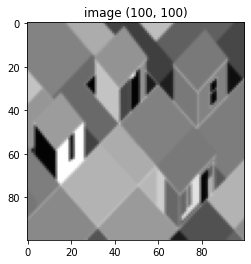

In [84]:
# Read image
img = io.imread("imgs/houses.png")
img = np.sum(img, axis=2)
img = img / np.max(img)

img = transform.resize(img, (100, 100))

# noise = np.random.normal(0.01, 0.01, img.shape)
# img = img + noise

plt.figure()
plt.title(f"image {img.shape}")
plt.imshow(img, cmap='gray')


# Bayesian classification

## The principle

### Bayesian statistic :

The **Evidence** $p(x)$ is usually an observation of $X$.

The **Prior** $p(\theta)$ is a global knowledge of $\Theta$ independantly of $X$.

The **Likelyhood** $p(x|\theta)$ comes from the knowledge of the $x$ that are part of $\theta$.

The **Posterior** $p(\theta|x)$ is the outcome of $\theta$ for an observation $x$.

$\boxed{
Posterior = \frac{Likelihood \quad Prior}{Evidence}
}$

$\boxed{
p(\theta|x) = \frac{p(x|\theta) p(\theta)}{p(x)}
}$


### Application to image classification

We model the image as follow:

* $\Omega = {w_1, w_2, w_3, ...}$ the set of classes.
* $S = \{s\} $ the set of pixels.
* $y_s$ the gray level of pixel $s$.
* $Y_s$ the random variable associated with the pixel s.

We observe the **Evidence** $P(y_s)$ over $S$ which is the appearance frequencies of each gray level $y_s$.

We might have a **Prior** $P(w_i)$ which is the appearance frequencies of each class $w_i$ in the image that can be **learned from images classifications** or **modeled**.

We might also have a **Likelyhood** $P(y_s|w_i)$ which tells what are the gray levels associated with each classes and can be **learned from images classifications** or **modeled**.


We want to choose for each pixel y_s a class w_s such that the **Posterior** $P(w_i|y_s)$ is maximized.

$\boxed{
p(w_i|y_s) = \frac{p(y_s|w_i) p(w_i)}{p(y_s)}
}$

**NB:** if the classes are uniformly distributed ($p(w_i)$ is uniform), the in becomes a **Likelyhood maximization**.


## Classification by histogram modes

Here we assume that the classes are uniformly distributed. So do a **Likelyhood maximization**.

From the assumption that object of the same classe have very similar color, and the main classes have the most common colors in the image.

We associate each mode (local maximum) in the image histogram to each class. So each local maximum in the histogram will be a class.

We can then evaluate the **Likelyhood** $p(y_s|w_i)$ by measuring the distance from the color values of the maxima of the histogram associated with the class $w_i$ and the color value $y_s$ of the pixel. the smaller that distance, the higher is $p(y_s|w_i)$.

**Noise:** We can apply a gaussian filter to the histogram to reduce any eventual noise.

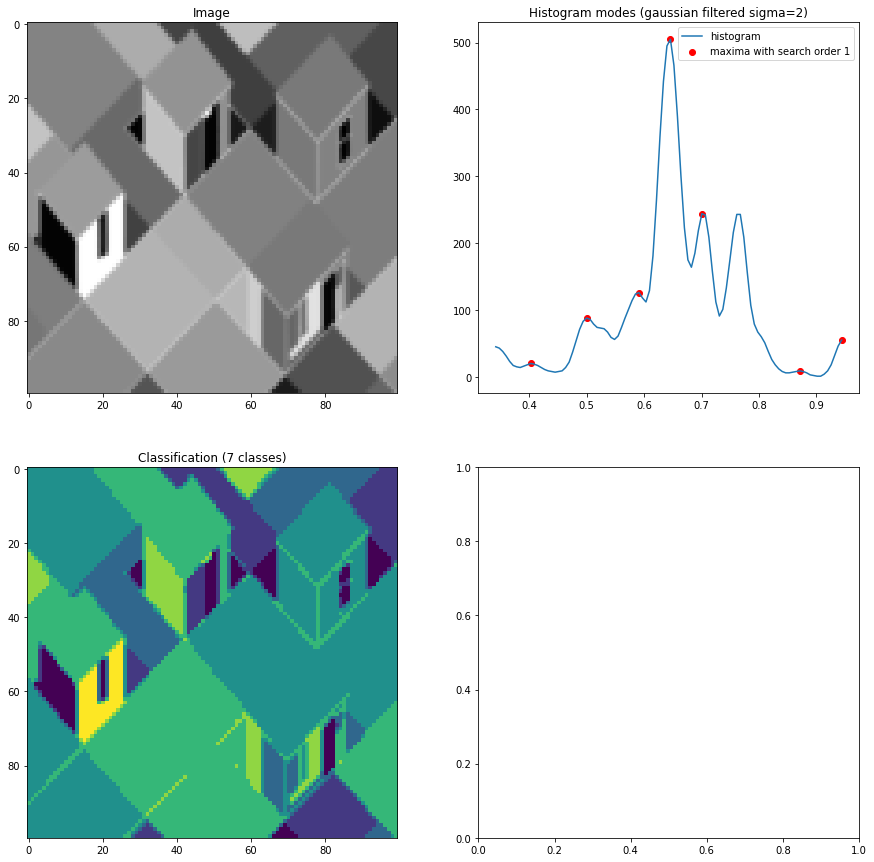

In [85]:

# Compute image histogram
hist, bins = np.histogram(img_filtered, bins=100)
bins = bins[:len(bins)-1]

# Filter the histogram with a gaussian to remove noise
filter_gauss_var = 2
hist = ndimage.gaussian_filter(hist, sigma=filter_gauss_var)

# Find local maxima in histogram
order = 1
hist_extrema_ind = signal.argrelmax(hist, order=order, mode='wrap')
hist_extrema_val = hist[hist_extrema_ind]
hist_maxima_ind_val = bins[hist_extrema_ind] # color values of the maxima

# Classification by histogram maxima
classes = np.zeros(img_filtered.shape)
for l in range(img_filtered.shape[0]):
  for c in range(img_filtered.shape[1]):
    # For each pixel, find the maxima with the closest color value
    dist_to_maxima = np.abs(hist_maxima_ind_val-img_filtered[l,c])
    maxima_ind = np.argmin(dist_to_maxima)
    classes[l,c] = maxima_ind

fig, axisarray = plt.subplots(2, 2, figsize=(15,15))
# Image
axisarray[0,0].set_title('Image')
axisarray[0,0].imshow(img_filtered, cmap='gray')
# Histogram with local maxima
axisarray[0,1].set_title(f"Histogram modes (gaussian filtered sigma={filter_gauss_var})")
axisarray[0,1].plot(bins, hist, label="histogram")
axisarray[0,1].scatter(bins[hist_extrema_ind], hist_extrema_val,
  color='r', label=f"maxima with search order {order}")
axisarray[0,1].legend()
# Classes
axisarray[1,0].set_title(f"Classification ({len(hist_extrema_val)} classes)")
axisarray[1,0].imshow(classes)


## Fingerprint (based on histogram modes)

modes [[0, 0, 6], [6, 11, 16], [17, 27, 33], [33, 41, 42], [42, 50, 55], [55, 60, 64], [64, 70, 83], [83, 87, 87], [92, 99, 99]]


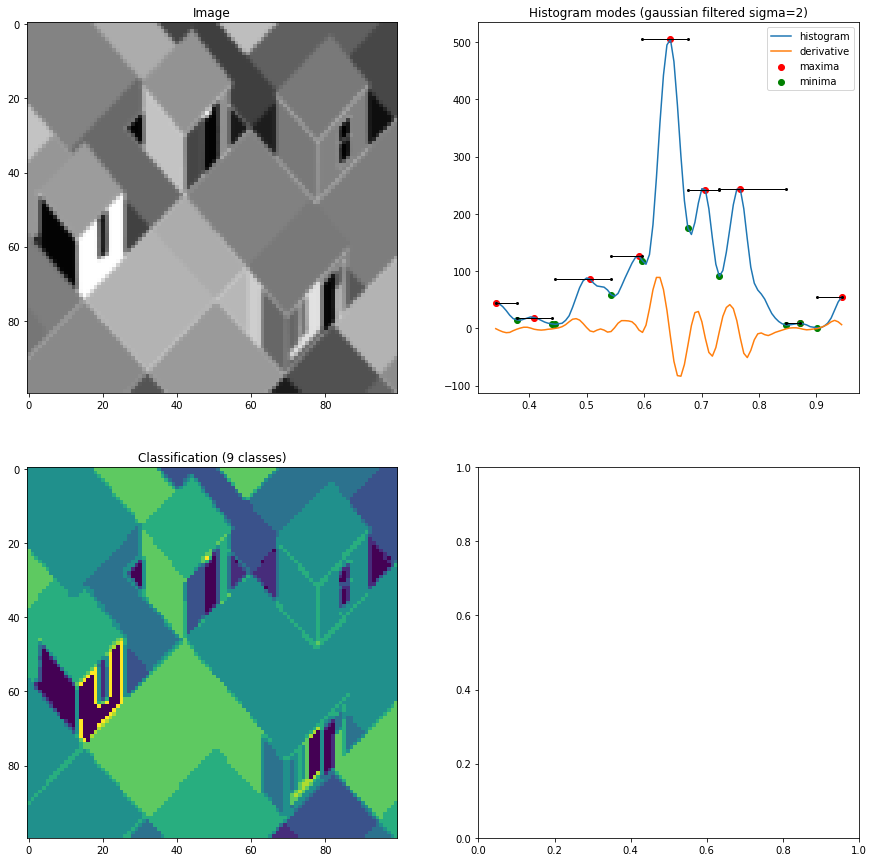

In [89]:

# Compute image histogram
hist, bins = np.histogram(img_filtered, bins=100)
bins = bins[:len(bins)-1]
# Filter the histogram with a gaussian to remove noise
filter_gauss_var = 2
hist = ndimage.gaussian_filter(hist, sigma=filter_gauss_var)

# Histogram derivative
hist_derivative = np.gradient(hist, edge_order=2)
# Find the zeros of the derivative and which ones are minima and maxima
hist_derivative_zero_ind = []
hist_derivative_zero_ismaximum = []
hist_derivative_zero_maximum_ind = []
hist_derivative_zero_minimum_ind = []
for i in range(0, len(hist_derivative)):
  if i==0:
    # First is a zero
    hist_derivative_zero_ind.append(i)
    if hist_derivative[i]<0:
      # is maximum
      hist_derivative_zero_ismaximum.append(True)
      hist_derivative_zero_maximum_ind.append(i)
    else:
      # is minimum
      hist_derivative_zero_ismaximum.append(False)
      hist_derivative_zero_minimum_ind.append(i)
  elif i==len(hist_derivative)-1:
    # Last is zero
    hist_derivative_zero_ind.append(i)
    if hist_derivative[i]>0:
      # is maximum
      hist_derivative_zero_ismaximum.append(True)
      hist_derivative_zero_maximum_ind.append(i)
    else:
      # is minimum
      hist_derivative_zero_ismaximum.append(False)
      hist_derivative_zero_minimum_ind.append(i)
  else:
    # Others
    if hist_derivative[i-1]*hist_derivative[i] <= 0:
      if hist_derivative[i-1]>0:
        hist_derivative_zero_ind.append(i)
        hist_derivative_zero_ismaximum.append(True)
        hist_derivative_zero_maximum_ind.append(i)
      else:
        hist_derivative_zero_ind.append(i-1)
        hist_derivative_zero_ismaximum.append(False)
        hist_derivative_zero_minimum_ind.append(i-1)

# Find the modes :
# Each mode is identified by a maximum and the adjacent minima
modes = []
for i in range(len(hist_derivative_zero_ind)):
  if hist_derivative_zero_ismaximum[i]:
    if i==0:
      if (not hist_derivative_zero_ismaximum[i+1]):
        modes.append([hist_derivative_zero_ind[i], hist_derivative_zero_ind[i], hist_derivative_zero_ind[i+1]])
    elif i==len(hist_derivative_zero_ind)-1:
      if (not hist_derivative_zero_ismaximum[i-1]):
        modes.append([hist_derivative_zero_ind[i-1], hist_derivative_zero_ind[i], hist_derivative_zero_ind[i]])
    else:
      if (not hist_derivative_zero_ismaximum[i+1]) and (not hist_derivative_zero_ismaximum[i-1]):
        modes.append([hist_derivative_zero_ind[i-1], hist_derivative_zero_ind[i], hist_derivative_zero_ind[i+1]])

print(f"modes {modes}")

classes = np.zeros(img_filtered.shape)
for l in range(0, img_filtered.shape[0]):
  for c in range(0, img_filtered.shape[1]):
    # For each pixel
    for i, mode in enumerate(modes):
      if bins[mode[0]]<img_filtered[l,c] and img_filtered[l,c]<bins[mode[2]]:
        classes[l,c] = i

fig, axisarray = plt.subplots(2, 2, figsize=(15,15))
# Image
axisarray[0,0].set_title('Image')
axisarray[0,0].imshow(img_filtered, cmap='gray')
# Histogram with local maxima
axisarray[0,1].set_title(f"Histogram modes (gaussian filtered sigma={filter_gauss_var})")
axisarray[0,1].plot(bins, hist, label="histogram")
axisarray[0,1].plot(bins, hist_derivative, label="derivative")
axisarray[0,1].scatter(bins[hist_derivative_zero_maximum_ind], hist[hist_derivative_zero_maximum_ind],
  color='r', label="maxima")
axisarray[0,1].scatter(bins[hist_derivative_zero_minimum_ind], hist[hist_derivative_zero_minimum_ind],
  color='g', label="minima")
# Display modes
for mode in modes:
  axisarray[0,1].plot([bins[mode[0]], bins[mode[2]]], [hist[mode[1]], hist[mode[1]]],
    color='black', marker='o', linewidth=1, markersize=2)
axisarray[0,1].legend()

# Classes
axisarray[1,0].set_title(f"Classification ({len(modes)} classes)")
axisarray[1,0].imshow(classes)

# K-means classification


Start centers : [0.37208089 0.43291448 0.49374807 0.55458167 0.61541526 0.67624885
 0.73708245 0.79791604 0.85874964 0.91958323]
End centers : [0.35683421 0.41624559 0.51122828 0.58044372 0.6340121  0.65777077
 0.70524776 0.76740096 0.82753115 0.94515186]


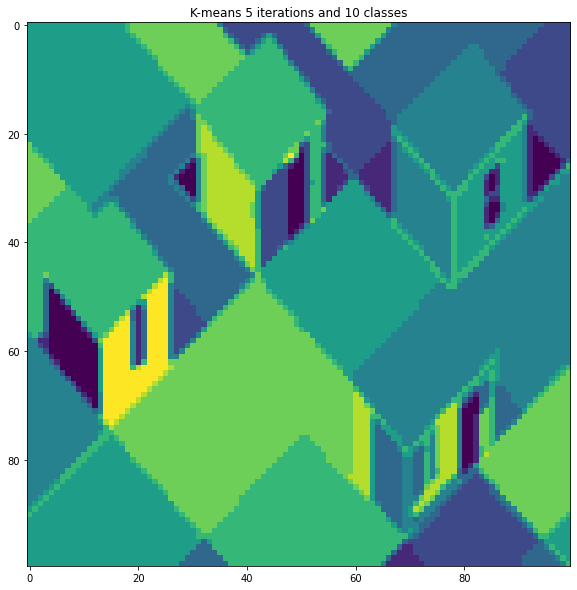

In [88]:
n_classes = 10

# Initial classes centers
max_val = np.max(img)
min_val = np.min(img)
interval = float(max_val-min_val)/n_classes
classes_center = np.array([ interval/2 + min_val + interval*i for i in range(n_classes) ])

classification = np.zeros(img.shape)

classes_pixel_values = []
def update_pixel_class():
  global classes_pixel_values
  classes_pixel_values = [[] for i in range(n_classes)]
  for l in range(0, img.shape[0]):
    for c in range(0, img.shape[1]):
      dist_to_classes = np.abs(classes_center-img[l,c])
      class_index = np.argmin(dist_to_classes)
      classes_pixel_values[class_index].append(img[l,c])
      classification[l,c] = class_index

def update_class_centers():
  for i in range(n_classes):
    center = np.mean(np.array(classes_pixel_values[i]))
    classes_center[i] = center

n_iterations = 5

print(f"Start centers : {classes_center}")
for i in range(n_iterations):
  update_pixel_class()
  update_class_centers()
print(f"End centers : {classes_center}")

plt.figure(figsize=(10,10))
plt.title(f"K-means {n_iterations} iterations and {n_classes} classes")
plt.imshow(classification)
